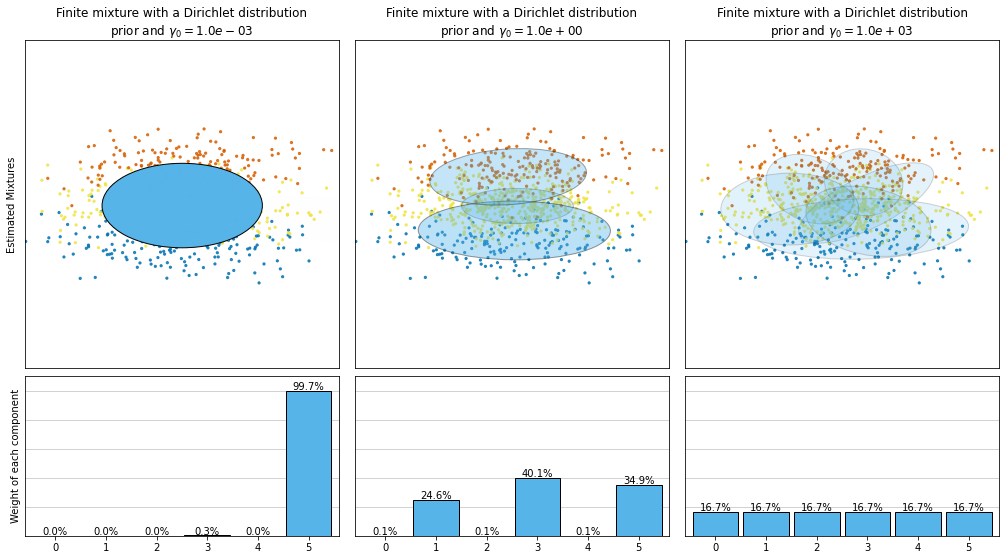

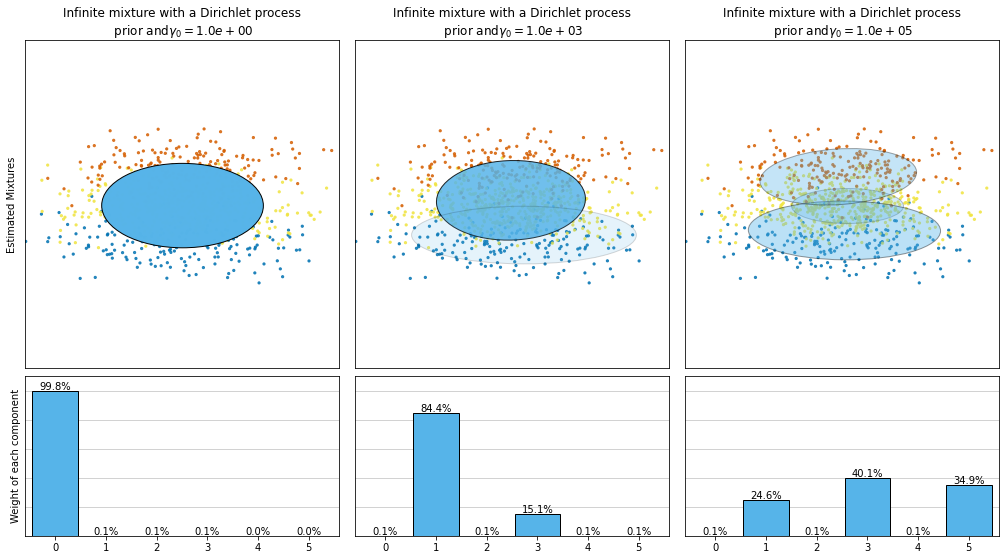

In [1]:
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.mixture import BayesianGaussianMixture

# 클러스터의 타원을 그리는 함수 정의
def plot_ellipses(ax, weights, means, covars):
    for n in range(means.shape[0]):
        eig_vals, eig_vecs = np.linalg.eigh(covars[n])
        unit_eig_vec = eig_vecs[0] / np.linalg.norm(eig_vecs[0])
        angle = np.arctan2(unit_eig_vec[1], unit_eig_vec[0])
        # Ellipse needs degrees
        angle = 180 * angle / np.pi
        # eigenvector normalization
        eig_vals = 2 * np.sqrt(2) * np.sqrt(eig_vals)
        ell = mpl.patches.Ellipse(
            means[n], eig_vals[0], eig_vals[1], angle=180 + angle, edgecolor="black"
        )
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(weights[n])
        ell.set_facecolor("#56B4E9")
        ax.add_artist(ell)

# 결과를 그리는 함수 정의
def plot_results(ax1, ax2, estimator, X, y, title, plot_title=False):
    ax1.set_title(title)
    ax1.scatter(X[:, 0], X[:, 1], s=5, marker="o", color=colors[y], alpha=0.8)
    ax1.set_xlim(-2.0, 2.0)
    ax1.set_ylim(-3.0, 3.0)
    ax1.set_xticks(())
    ax1.set_yticks(())
    plot_ellipses(ax1, estimator.weights_, estimator.means_, estimator.covariances_)

    ax2.get_xaxis().set_tick_params(direction="out")
    ax2.yaxis.grid(True, alpha=0.7)
    for k, w in enumerate(estimator.weights_):
        ax2.bar(
            k,
            w,
            width=0.9,
            color="#56B4E9",
            zorder=3,
            align="center",
            edgecolor="black",
        )
        ax2.text(k, w + 0.007, "%.1f%%" % (w * 100.0), horizontalalignment="center")
    ax2.set_xlim(-0.6, 2 * n_components - 0.4)
    ax2.set_ylim(0.0, 1.1)
    ax2.tick_params(axis="y", which="both", left=False, right=False, labelleft=False)
    ax2.tick_params(axis="x", which="both", top=False)

    if plot_title:
        ax1.set_ylabel("Estimated Mixtures")
        ax2.set_ylabel("Weight of each component")


# 데이터셋과 모델의 파라미터 설정
random_state, n_components, n_features = 2, 3, 2
colors = np.array(["#0072B2", "#F0E442", "#D55E00"])

# 각 클러스터의 공분산 정의
covars = np.array(
    [[[0.7, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]], [[0.5, 0.0], [0.0, 0.1]]]
)
# 각 클러스터의 샘플 수와 평균 정의
samples = np.array([200, 500, 200])
means = np.array([[0.0, -0.70], [0.0, 0.0], [0.0, 0.70]])

# 비교할 BayesianGaussianMixture 모델 정의
estimators = [
    (
        "Finite mixture with a Dirichlet distribution\nprior and " r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_distribution",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [0.001, 1, 1000],
    ),
    (
        "Infinite mixture with a Dirichlet process\n prior and" r"$\gamma_0=$",
        BayesianGaussianMixture(
            weight_concentration_prior_type="dirichlet_process",
            n_components=2 * n_components,
            reg_covar=0,
            init_params="random",
            max_iter=1500,
            mean_precision_prior=0.8,
            random_state=random_state,
        ),
        [1, 1000, 100000],
    ),
]

# 데이터 생성
rng = np.random.RandomState(random_state)
X = np.vstack(
    [
        rng.multivariate_normal(means[j], covars[j], samples[j])
        for j in range(n_components)
    ]
)
y = np.concatenate([np.full(samples[j], j, dtype=int) for j in range(n_components)])

# 각 사전 설정에 대한 결과를 두 개의 다른 그림으로 표시
for title, estimator, concentrations_prior in estimators:
    plt.figure(figsize=(4.7 * 3, 8))
    plt.subplots_adjust(
        bottom=0.04, top=0.90, hspace=0.05, wspace=0.05, left=0.03, right=0.99
    )

    gs = gridspec.GridSpec(3, len(concentrations_prior))
    for k, concentration in enumerate(concentrations_prior):
        estimator.weight_concentration_prior = concentration
        estimator.fit(X)
        plot_results(
            plt.subplot(gs[0:2, k]),
            plt.subplot(gs[2, k]),
            estimator,
            X,
            y,
            r"%s$%.1e$" % (title, concentration),
            plot_title=k == 0,
        )

plt.show()